In [2]:
# Check for GPU
!nvidia-smi

FileNotFoundError: [Errno 2] No such file or directory: '/bin/bash'

In [3]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.9.0+cu126


'cpu'

In [4]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [5]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Image class: steak


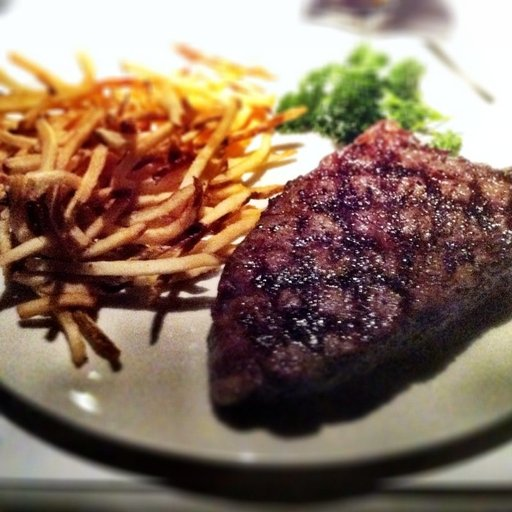

In [8]:
# Visualize an image
from PIL import Image
import random

imgList = list(image_path.glob("*/*/*.jpg"))
randomImg = random.choice(imgList)
label = randomImg.parent.stem
img = Image.open(randomImg)
print(f"Image class: {label}")
img

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [9]:
# 3.1 Transforming data with torchvision.transforms

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [10]:
# Write transform for turning images into tensors
train_transform = transforms.Compose([transforms.Resize(size=(128,128)),
                                      transforms.TrivialAugmentWide(),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize(size=(128,128)),
                                      transforms.ToTensor()])

In [11]:
# Write a function to plot transformed images
import matplotlib.pyplot as plt
import numpy as np

def plot_transformed_image(image_path, transform):

  image = Image.open(image_path)
  img_array = np.asarray(image)
  label = image_path.parent.stem
  transformed_img = transform(image).permute(1,2,0)

  fig, ax = plt.subplots(1,2)
  ax[0].imshow(img_array)
  ax[0].set_title(f"Original image of class:{label}")
  ax[0].axis("off")

  ax[1].imshow(transformed_img)
  ax[1].set_title(f"Image transformed")
  ax[1].axis("off")

  fig.suptitle("Orgignal Image vs transformed image ")


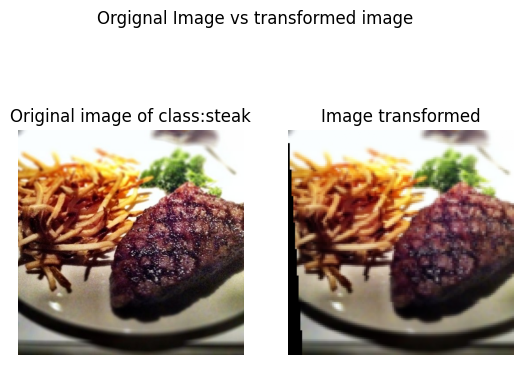

In [12]:
plot_transformed_image(randomImg, train_transform)

### Load image data using `ImageFolder`

In [13]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(train_dir,train_transform)
test_data = datasets.ImageFolder(test_dir, test_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [14]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [17]:
# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(train_data, batch_size= 32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size= 32, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79721bf9ed50>,
 <torch.utils.data.dataloader.DataLoader at 0x79721c1fe960>)

In [18]:
# How many batches of images are in our data loaders?
IMAGES, LABELS = next(iter(train_dataloader))

print(IMAGES.shape)

torch.Size([32, 3, 128, 128])


## 3. Building a Model

In [19]:
import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self):
    super().__init__()

    self.convBlock1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size=3, stride = 1, padding = 1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride = 2))

    self.convBlock2 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size=3, padding = 1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels = 10, out_channels=10, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2))

    self.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(in_features=10240, out_features=3))

  def forward(self, x):
    return self.classifier(self.convBlock2(self.convBlock1(x)))



In [20]:
model = TinyVGG()
model

TinyVGG(
  (convBlock1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convBlock2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10240, out_features=3, bias=True)
  )
)

In [21]:
# making a prediction
img_batch, label_batch = next(iter(train_dataloader))
img, label = img_batch[0].unsqueeze(dim=0), label_batch[0]

model.eval()
with torch.inference_mode():
  pred = model(img)

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:{label}")

Output logits:
tensor([[ 0.0014, -0.0209,  0.0113]])

Output prediction probabilities:
tensor([[0.3347, 0.3273, 0.3380]])

Output prediction label:
tensor([2])

Actual label:1


## Training and Testing

Epoch [1/50]
  Train Loss: 1.1266, Train Acc: 29.78%
  Test Loss: 1.0997, Test Acc: 33.33%
------------------------------------------------------------
Epoch [2/50]
  Train Loss: 1.0989, Train Acc: 34.67%
  Test Loss: 1.1158, Test Acc: 33.33%
------------------------------------------------------------
Epoch [3/50]
  Train Loss: 1.0997, Train Acc: 34.67%
  Test Loss: 1.0922, Test Acc: 41.33%
------------------------------------------------------------
Epoch [4/50]
  Train Loss: 1.0992, Train Acc: 33.33%
  Test Loss: 1.1014, Test Acc: 25.33%
------------------------------------------------------------
Epoch [5/50]
  Train Loss: 1.0981, Train Acc: 33.33%
  Test Loss: 1.1010, Test Acc: 25.33%
------------------------------------------------------------
Epoch [6/50]
  Train Loss: 1.0977, Train Acc: 36.89%
  Test Loss: 1.1006, Test Acc: 33.33%
------------------------------------------------------------
Epoch [7/50]
  Train Loss: 1.0984, Train Acc: 34.67%
  Test Loss: 1.0988, Test Acc: 33.3

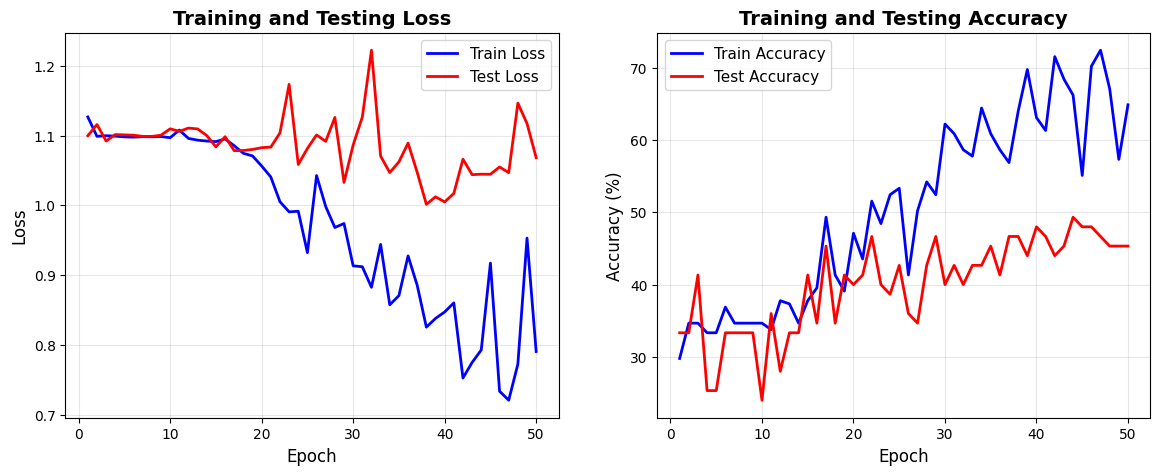

In [23]:
# Storage for results
train_losses = []
train_accs = []
test_losses = []
test_accs = []

lossfun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
EPOCHS = 50

model.to(device)

for epoch in range(EPOCHS):

  model.train()
  train_loss = 0.0
  train_correct = 0
  train_total = 0

  for inputs, labels in train_dataloader:

    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    output = model(inputs) # Corrected: passed 'inputs' tensor to the model
    loss = lossfun(output, labels) # Corrected: passed model 'output' and batch 'labels'
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * inputs.size(0)
    _, predicted = torch.max(output.data, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

  train_loss = train_loss / train_total
  train_acc = 100 * train_correct / train_total

  # Testing phase
  test_loss = 0.0
  test_correct = 0
  test_total = 0
  model.eval()
  with torch.inference_mode():
    for inputs, labels in test_dataloader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      loss = lossfun(outputs, labels)

      test_loss += loss.item() * inputs.size(0)
      _, predicted = torch.max(outputs.data, 1)
      test_total += labels.size(0)
      test_correct += (predicted == labels).sum().item()

  test_loss = test_loss / test_total
  test_acc = 100 * test_correct / test_total

  # Save results
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)

  # Print progress
  print(f'Epoch [{epoch+1}/{EPOCHS}]')
  print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
  print(f'  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
  print('-' * 60)


# Plot results
epochs = range(1, EPOCHS + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs, test_losses, 'r-', label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Testing Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(epochs, train_accs, 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(epochs, test_accs, 'r-', label='Test Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Testing Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

## looks like our model isn't preforming as we hoped, let's try:
* increasing the data
* adding more layers
* changing the transform

### Inreasing the data

In [26]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [27]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Changing the data transforms

In [28]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = datasets.ImageFolder(train_data_20_percent_path,
                                     train_transform)
test_dataset = datasets.ImageFolder(test_data_20_percent_path,
                                    test_transform)

# Create dataloaders
training_dataloader = DataLoader(train_dataset, 32, shuffle = True)
testing_dataloader = DataLoader(test_dataset, batch_size= 32, shuffle = False)

### increasing model complexity

In [53]:
import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self):
    super().__init__()

    self.convBlock1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size=3, stride = 1, padding = 1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride = 2))

    self.convBlock2 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size=3, padding = 1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels = 10, out_channels=10, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2))

    self.convBlock3 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size=3, padding = 1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels = 10, out_channels=10, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2))

    self.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(in_features=7840, out_features=3))

  def forward(self, x):
    return self.classifier(self.convBlock3(self.convBlock2(self.convBlock1(x))))



In [54]:
model2 = TinyVGG()

Epoch [1/10]
  Train Loss: 1.1062, Train Acc: 30.44%
  Test Loss: 1.1027, Test Acc: 30.67%
------------------------------------------------------------
Epoch [2/10]
  Train Loss: 1.0987, Train Acc: 34.22%
  Test Loss: 1.1000, Test Acc: 30.67%
------------------------------------------------------------
Epoch [3/10]
  Train Loss: 1.0977, Train Acc: 34.22%
  Test Loss: 1.0987, Test Acc: 30.67%
------------------------------------------------------------
Epoch [4/10]
  Train Loss: 1.0942, Train Acc: 34.22%
  Test Loss: 1.0942, Test Acc: 30.67%
------------------------------------------------------------
Epoch [5/10]
  Train Loss: 1.0766, Train Acc: 34.22%
  Test Loss: 1.0748, Test Acc: 30.67%
------------------------------------------------------------
Epoch [6/10]
  Train Loss: 1.0239, Train Acc: 44.89%
  Test Loss: 1.0103, Test Acc: 50.67%
------------------------------------------------------------
Epoch [7/10]
  Train Loss: 0.9750, Train Acc: 54.67%
  Test Loss: 1.0051, Test Acc: 47.3

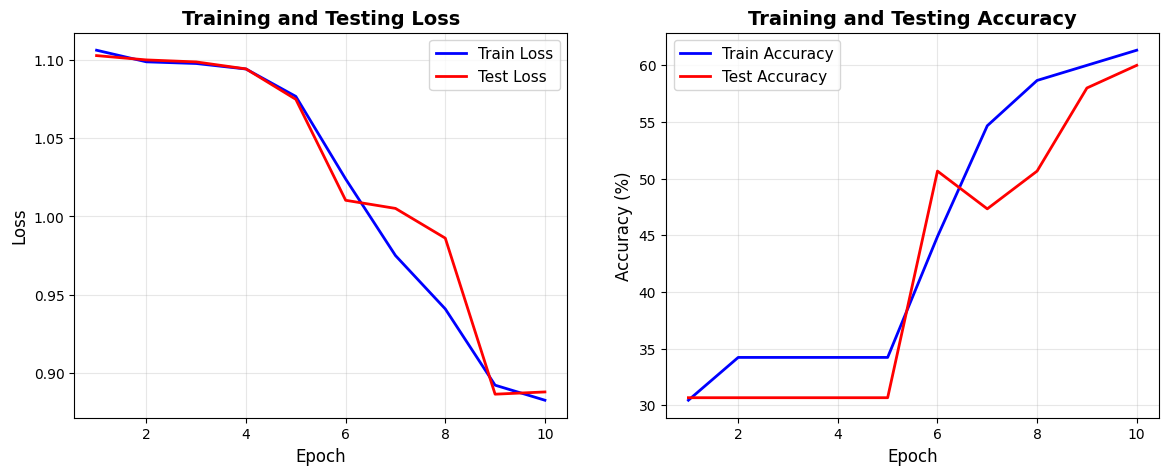

In [55]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Storage for results
train_losses = []
train_accs = []
test_losses = []
test_accs = []

lossfun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(),lr = 0.001)
EPOCHS = 10

model2.to(device)

for epoch in range(EPOCHS):

  model2.train()
  train_loss = 0.0
  train_correct = 0
  train_total = 0

  for inputs, labels in training_dataloader: # Changed to training_dataloader

    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    output = model2(inputs)
    loss = lossfun(output, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * inputs.size(0)
    _, predicted = torch.max(output.data, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

  train_loss = train_loss / train_total
  train_acc = 100 * train_correct / train_total

  # Testing phase
  test_loss = 0.0
  test_correct = 0
  test_total = 0
  model2.eval()
  with torch.inference_mode():
    for inputs, labels in testing_dataloader: # Changed to testing_dataloader
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model2(inputs)
      loss = lossfun(outputs, labels)

      test_loss += loss.item() * inputs.size(0)
      _, predicted = torch.max(outputs.data, 1)
      test_total += labels.size(0)
      test_correct += (predicted == labels).sum().item()

  test_loss = test_loss / test_total
  test_acc = 100 * test_correct / test_total

  # Save results
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)

  # Print progress
  print(f'Epoch [{epoch+1}/{EPOCHS}]')
  print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
  print(f'  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
  print('-' * 60)


# Plot results
epochs = range(1, EPOCHS + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs, test_losses, 'r-', label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Testing Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(epochs, train_accs, 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(epochs, test_accs, 'r-', label='Test Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Testing Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

## 8. Making a prediction on a custom image of pizza/steak/sushi (you could even download one from the internet).

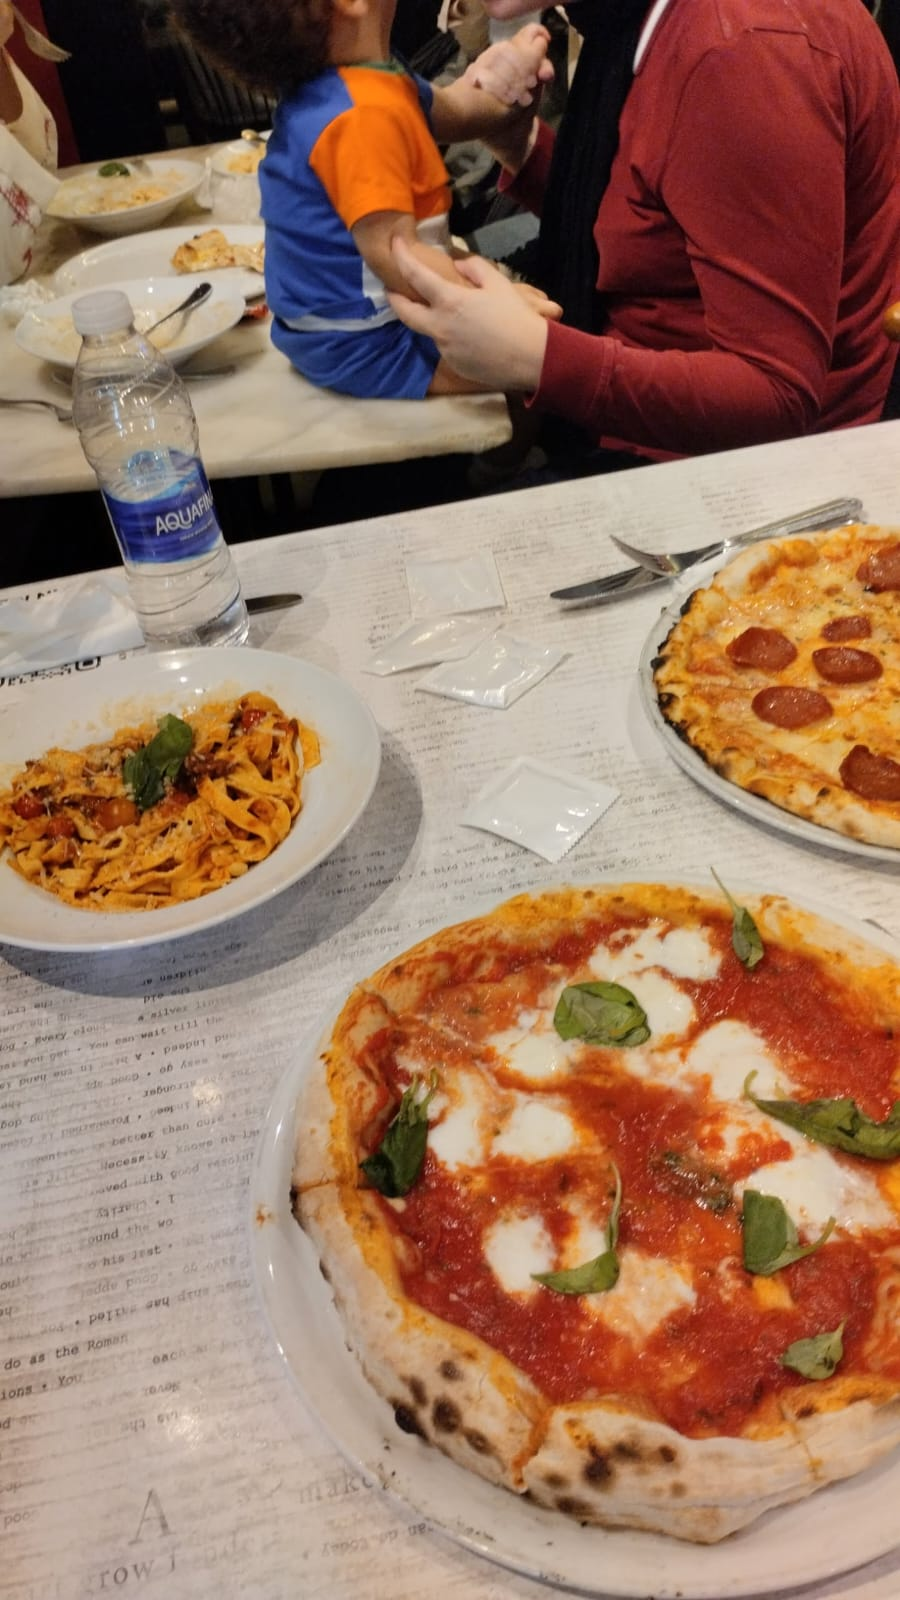

In [56]:
imagePath = "/content/WhatsApp Image 2025-12-09 at 00.44.31_a414f10d.jpg"
from PIL import Image
img = Image.open(imagePath)
img

In [57]:
imgTrans = test_transform(img).unsqueeze(dim=1).permute(1,0,2,3)
imgTrans

tensor([[[[ 0.5193,  0.3652, -0.1657,  ..., -1.9295, -1.9295, -1.8953],
          [ 0.4679,  0.5707,  0.1939,  ..., -1.9295, -1.9124, -1.9124],
          [ 0.2796,  0.3309,  0.1597,  ..., -1.9295, -1.9124, -1.9124],
          ...,
          [ 0.9988,  1.0159,  1.0331,  ...,  1.3584,  1.3755,  1.3927],
          [ 0.9646,  0.9817,  0.9988,  ...,  1.3584,  1.3242,  1.3413],
          [ 1.0844,  1.0331,  0.9817,  ...,  1.4269,  1.4612,  1.4954]],

         [[-0.1975, -0.3550, -0.8452,  ..., -1.8957, -1.8782, -1.8431],
          [-0.3025, -0.1975, -0.5126,  ..., -1.8782, -1.8606, -1.8606],
          [-0.4076, -0.3901, -0.5476,  ..., -1.8957, -1.8606, -1.8606],
          ...,
          [ 0.6779,  0.6954,  0.7129,  ...,  1.0630,  1.0805,  1.0805],
          [ 0.6429,  0.6779,  0.6954,  ...,  1.0455,  1.0280,  1.0455],
          [ 0.8004,  0.7654,  0.6954,  ...,  1.1155,  1.1681,  1.2031]],

         [[-0.6890, -0.8633, -1.2119,  ..., -1.5604, -1.5430, -1.5256],
          [-0.7936, -0.7238, -

In [58]:
with torch.inference_mode():
  pred = model2(imgTrans)


In [59]:
proba = torch.softmax(pred, dim = 1)
label = torch.argmax(proba, dim = 1)
print(label)

tensor([0])


In [61]:
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [60]:
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}